In [1]:
!git clone https://github.com/guillepinto/gsoc25-exxa.git
%cd gsoc25-exxa

Cloning into 'gsoc25-exxa'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 1), reused 9 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 2.65 MiB | 30.13 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/kaggle/working/gsoc25-exxa


In [2]:
!curl -L 'https://storage.googleapis.com/drive-bulk-export-anonymous/20250407T194920.722Z/4133399871716478688/20353a63-6680-4e3e-b9d9-5e5606ca3407/1/dbb68393-d861-4df1-82da-18d426c57e41?authuser' \
  --output dataset.zip

!unzip dataset.zip -d ./

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  604M  100  604M    0     0   106M      0  0:00:05  0:00:05 --:--:--  119M 168M    0     0  78.8M      0  0:00:07  0:00:02  0:00:05 78.8M
Archive:  dataset.zip
  inflating: ./continuum_data_subset/planet80_00754_1250.fits  
  inflating: ./continuum_data_subset/planet8_00248_1250.fits  
  inflating: ./continuum_data_subset/planet8_00128_1250.fits  
  inflating: ./continuum_data_subset/planet8_00214_1250.fits  
  inflating: ./continuum_data_subset/planet8_00320_1250.fits  
  inflating: ./continuum_data_subset/planet72_00984_1250.fits  
  inflating: ./continuum_data_subset/planet88_00674_1250.fits  
  inflating: ./continuum_data_subset/planet99_00400_1250.fits  
  inflating: ./continuum_data_subset/planet92_00530_1250.fits  
  inflating: ./continuum_data_subset/planet68_00920_1250.fits  
  inflating: ./continuum_data_subset/plane

In [3]:
import numpy as np
import glob
from astropy.io import fits
from tqdm import tqdm
from PIL import Image

### PyTorch Dataset 

In [4]:
import os

class ALMADataset:
    def __init__(self, fits_dir, transform=None):
        self.files = sorted(glob.glob(os.path.join(fits_dir, '*.fits')))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        file = self.files[index]
        with fits.open(file) as hdul:
            image = hdul[0].data[0, 0, 0, ...]
        image = np.array(image, dtype=np.float32).copy()
        label = -1  # dummy label
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [5]:
class LogTransform(object):
    def __init__(self, scale_factor=1e21, eps=1e-10):
        self.scale_factor = scale_factor
        self.eps = eps

    def __call__(self, image):
        # image is a numpy array
        arr = np.array(image, dtype=np.float32)
        arr = np.log1p(arr * self.scale_factor + self.eps)
        return Image.fromarray(arr)

dataset = ALMADataset(fits_dir='continuum_data_subset', transform=LogTransform(scale_factor=1e21))
dataset[0][0].size

(600, 600)

Compute statistics

In [6]:
sum_pixels = 0.0
sum_sq_pixels = 0.0
num_pixels = 0

# Iterate over the dataset
for i in tqdm(range(len(dataset)), desc="Computing stats"):
    img, _ = dataset[i]
    # Ensure the image is a numpy array
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    pixels = img.flatten()  # Flatten the image to a 1D array
    sum_pixels += np.sum(pixels)
    sum_sq_pixels += np.sum(pixels**2)
    num_pixels += pixels.size

# Compute global mean and standard deviation
global_mean = sum_pixels / num_pixels
global_std = np.sqrt((sum_sq_pixels / num_pixels) - global_mean**2)

print("Global Mean:", global_mean)
print("Global Std:", global_std)

Computing stats: 100%|██████████| 150/150 [00:01<00:00, 143.08it/s]

Global Mean: 0.10948892747214989
Global Std: 0.23363521748988333


In [7]:
from torchvision import transforms
    
alma_transform = transforms.Compose([
    LogTransform(scale_factor=1e21),
    transforms.RandomResizedCrop(224),      
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.10948892767107929], std=[0.23363521474947446])
    ])

In [8]:
dataset = ALMADataset(fits_dir='continuum_data_subset', transform=alma_transform)
dataset[0][0].shape

torch.Size([1, 224, 224])

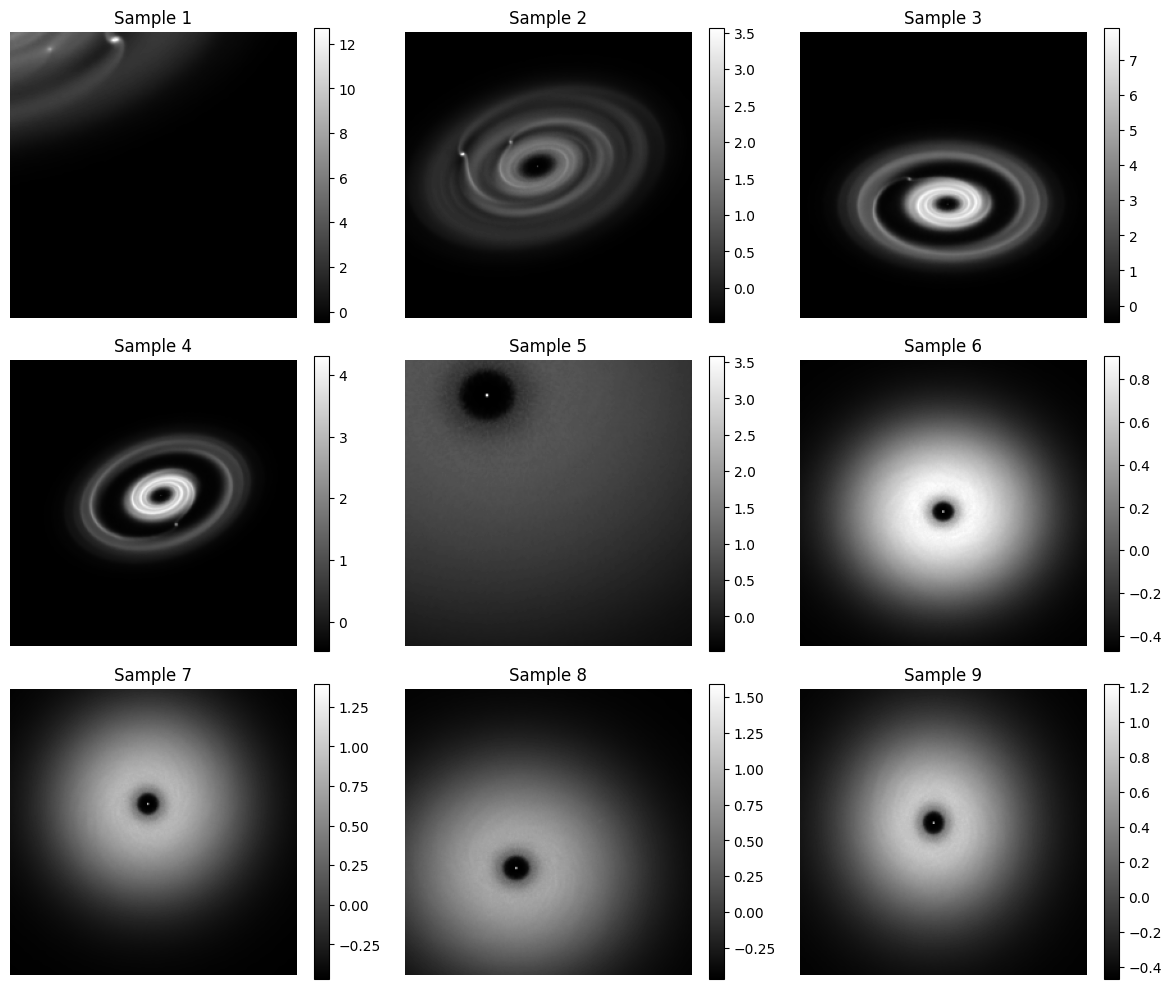

In [9]:
import matplotlib.pyplot as plt

# Collect 9 sample images from the dataset (ignoring labels)
samples = [dataset[i][0] for i in range(9)]

plt.figure(figsize=(12, 10))
for i, img in enumerate(samples):
    # If the image is a torch tensor, convert to numpy
    if hasattr(img, "cpu"):
        img = img.cpu().numpy()
    # Assume image shape is (C, H, W). If single channel, remove channel dimension.
    if img.shape[0] == 1:
        img = img.squeeze(0)
    elif img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.colorbar()
    plt.title(f"Sample {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Pre-training

In [10]:
def pretrain_model(model, dataloader, optimizer, num_epochs=10, mask_ratio=0.75, device="cuda"):
    """
    Minimal training loop with MS-SSIM loss and progress bar.
    The PyTorch differentiable Multi-Scale Structural Similarity (MS-SSIM) loss is calculated 
    alongside the MSE loss and both are used in the backward pass.
    Parameters:
      model: Model to be trained.
      dataloader: DataLoader providing images.
      optimizer: Optimizer used to update model parameters.
      num_epochs: Number of training epochs.
      mask_ratio: Ratio of patches to mask.
      device: Device to use.
    """
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        total_mse = 0.0
        total_ms_ssim = 0.0
        total_loss = 0.0
        
        # Wrap the dataloader with tqdm for a progress bar.
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for imgs, _ in pbar:  # each item is expected to be (image, dummy_label)
            imgs = imgs.to(device)
            optimizer.zero_grad()
            # Forward pass with MS-SSIM loss calculation; both losses are returned
            mse_loss, ms_ssim_loss, _, _ = model(imgs, mask_ratio=mask_ratio, compute_ms_ssim=True)
            loss = mse_loss + ms_ssim_loss
            loss.backward()
            optimizer.step()
            
            total_mse += mse_loss.item()
            total_ms_ssim += ms_ssim_loss.item()
            total_loss += loss.item()
            
            # Update the progress bar description with current loss values.
            pbar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "MSE": f"{mse_loss.item():.4f}",
                "MS-SSIM": f"{ms_ssim_loss.item():.4f}"
            })
        avg_mse = total_mse / len(dataloader)
        avg_ms_ssim = total_ms_ssim / len(dataloader)
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}: Total Loss = {avg_loss:.4f}, MSE = {avg_mse:.4f}, MS-SSIM Loss = {avg_ms_ssim:.4f}")
    return model

In the modified MAE model, I changed the number of input channels in the patch embedding layer. This layer divides the image into patches using a 2D convolution, where the input filters equal the number of channels and the output filters represent the embedding size.

Additionally, I implemented the MS-SSIM loss in the forward pass by introducing two separate branches, since MS-SSIM requires unmasked patches. The rest of the code remains unchanged and is based on the official MAE repository.

In [11]:
import torch
from torch.utils.data import DataLoader
from models_mae import mae_vit_base_patch16

# Using the previously defined ALMADataset
# Adjust parameters as needed, e.g., use a small batch_size for testing
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Instantiate the model with minimal parameters (modify in_channels as required)
model = mae_vit_base_patch16(img_size=224, in_chans=1, norm_pix_loss=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Run a simple pre-training for 2 epochs (adjust num_epochs as preferred)
device = "cuda" if torch.cuda.is_available() else "cpu"
pretrain_model(model, dataloader, optimizer, num_epochs=150, mask_ratio=0.75, device=device)

Epoch 1/150: Total Loss = 1.4827, MSE = 1.0114, MS-SSIM Loss = 0.4712


Epoch 2/150: Total Loss = 1.0928, MSE = 0.8087, MS-SSIM Loss = 0.2842


Epoch 3/150: Total Loss = 0.9448, MSE = 0.7518, MS-SSIM Loss = 0.1930


Epoch 4/150: Total Loss = 0.8620, MSE = 0.6941, MS-SSIM Loss = 0.1679


Epoch 5/150: Total Loss = 0.7709, MSE = 0.6319, MS-SSIM Loss = 0.1390


Epoch 6/150: Total Loss = 0.6934, MSE = 0.5820, MS-SSIM Loss = 0.1114


Epoch 7/150: Total Loss = 0.7083, MSE = 0.6113, MS-SSIM Loss = 0.0970


Epoch 8/150: Total Loss = 0.6911, MSE = 0.6049, MS-SSIM Loss = 0.0862


Epoch 9/150: Total Loss = 0.6684, MSE = 0.5811, MS-SSIM Loss = 0.0873


Epoch 10/150: Total Loss = 0.6811, MSE = 0.5864, MS-SSIM Loss = 0.0947


Epoch 11/150: Total Loss = 0.6972, MSE = 0.5875, MS-SSIM Loss = 0.1097


Epoch 12/150: Total Loss = 0.6750, MSE = 0.5854, MS-SSIM Loss = 0.0896


Epoch 13/150: Total Loss = 0.6655, MSE = 0.5852, MS-SSIM Loss = 0.0804


Epoch 14/150: Total Loss = 0.6391, MSE = 0.5619, MS-SSIM Loss = 0.0771


Epoch 15/150: Total Loss = 0.6497, MSE = 0.5743, MS-SSIM Loss = 0.0754


Epoch 16/150: Total Loss = 0.6033, MSE = 0.5368, MS-SSIM Loss = 0.0665


Epoch 17/150: Total Loss = 0.6063, MSE = 0.5475, MS-SSIM Loss = 0.0589


Epoch 18/150: Total Loss = 0.6055, MSE = 0.5374, MS-SSIM Loss = 0.0681


Epoch 19/150: Total Loss = 0.6088, MSE = 0.5373, MS-SSIM Loss = 0.0715


Epoch 20/150: Total Loss = 0.5720, MSE = 0.5042, MS-SSIM Loss = 0.0678


Epoch 21/150: Total Loss = 0.5697, MSE = 0.5097, MS-SSIM Loss = 0.0600


Epoch 22/150: Total Loss = 0.5786, MSE = 0.5134, MS-SSIM Loss = 0.0652


Epoch 23/150: Total Loss = 0.5462, MSE = 0.4817, MS-SSIM Loss = 0.0645


Epoch 24/150: Total Loss = 0.5460, MSE = 0.4846, MS-SSIM Loss = 0.0615


Epoch 25/150: Total Loss = 0.5056, MSE = 0.4514, MS-SSIM Loss = 0.0541


Epoch 26/150: Total Loss = 0.5152, MSE = 0.4613, MS-SSIM Loss = 0.0539


Epoch 27/150: Total Loss = 0.5028, MSE = 0.4500, MS-SSIM Loss = 0.0528


Epoch 28/150: Total Loss = 0.4892, MSE = 0.4398, MS-SSIM Loss = 0.0493


Epoch 29/150: Total Loss = 0.4758, MSE = 0.4224, MS-SSIM Loss = 0.0534


Epoch 30/150: Total Loss = 0.4756, MSE = 0.4246, MS-SSIM Loss = 0.0510


Epoch 31/150: Total Loss = 0.5096, MSE = 0.4500, MS-SSIM Loss = 0.0596


Epoch 32/150: Total Loss = 0.5035, MSE = 0.4517, MS-SSIM Loss = 0.0519


Epoch 33/150: Total Loss = 0.4902, MSE = 0.4377, MS-SSIM Loss = 0.0525


Epoch 34/150: Total Loss = 0.4343, MSE = 0.3905, MS-SSIM Loss = 0.0438


Epoch 35/150: Total Loss = 0.4542, MSE = 0.4094, MS-SSIM Loss = 0.0448


Epoch 36/150: Total Loss = 0.4465, MSE = 0.4015, MS-SSIM Loss = 0.0449


Epoch 37/150: Total Loss = 0.4362, MSE = 0.3896, MS-SSIM Loss = 0.0467


Epoch 38/150: Total Loss = 0.4406, MSE = 0.3982, MS-SSIM Loss = 0.0423


Epoch 39/150: Total Loss = 0.4246, MSE = 0.3850, MS-SSIM Loss = 0.0396


Epoch 40/150: Total Loss = 0.4503, MSE = 0.4097, MS-SSIM Loss = 0.0406


Epoch 41/150: Total Loss = 0.4024, MSE = 0.3651, MS-SSIM Loss = 0.0373


Epoch 42/150: Total Loss = 0.4057, MSE = 0.3652, MS-SSIM Loss = 0.0405


Epoch 43/150: Total Loss = 0.4002, MSE = 0.3627, MS-SSIM Loss = 0.0375


Epoch 44/150: Total Loss = 0.3984, MSE = 0.3586, MS-SSIM Loss = 0.0398


Epoch 45/150: Total Loss = 0.4144, MSE = 0.3730, MS-SSIM Loss = 0.0415


Epoch 46/150: Total Loss = 0.4104, MSE = 0.3737, MS-SSIM Loss = 0.0367


Epoch 47/150: Total Loss = 0.4027, MSE = 0.3667, MS-SSIM Loss = 0.0360


Epoch 48/150: Total Loss = 0.3778, MSE = 0.3440, MS-SSIM Loss = 0.0338


Epoch 49/150: Total Loss = 0.3892, MSE = 0.3523, MS-SSIM Loss = 0.0370


Epoch 50/150: Total Loss = 0.4012, MSE = 0.3646, MS-SSIM Loss = 0.0366


Epoch 51/150: Total Loss = 0.3853, MSE = 0.3497, MS-SSIM Loss = 0.0355


Epoch 52/150: Total Loss = 0.3843, MSE = 0.3524, MS-SSIM Loss = 0.0319


Epoch 53/150: Total Loss = 0.3623, MSE = 0.3306, MS-SSIM Loss = 0.0317


Epoch 54/150: Total Loss = 0.3712, MSE = 0.3397, MS-SSIM Loss = 0.0315


Epoch 55/150: Total Loss = 0.3826, MSE = 0.3489, MS-SSIM Loss = 0.0337


Epoch 56/150: Total Loss = 0.3869, MSE = 0.3538, MS-SSIM Loss = 0.0331


Epoch 57/150: Total Loss = 0.3689, MSE = 0.3375, MS-SSIM Loss = 0.0314


Epoch 58/150: Total Loss = 0.3814, MSE = 0.3522, MS-SSIM Loss = 0.0292


Epoch 59/150: Total Loss = 0.3825, MSE = 0.3433, MS-SSIM Loss = 0.0392


Epoch 60/150: Total Loss = 0.3735, MSE = 0.3413, MS-SSIM Loss = 0.0322


Epoch 61/150: Total Loss = 0.3799, MSE = 0.3518, MS-SSIM Loss = 0.0281


Epoch 62/150: Total Loss = 0.3501, MSE = 0.3211, MS-SSIM Loss = 0.0290


Epoch 63/150: Total Loss = 0.3842, MSE = 0.3550, MS-SSIM Loss = 0.0292


Epoch 64/150: Total Loss = 0.3637, MSE = 0.3328, MS-SSIM Loss = 0.0309


Epoch 65/150: Total Loss = 0.3631, MSE = 0.3351, MS-SSIM Loss = 0.0280


Epoch 66/150: Total Loss = 0.3465, MSE = 0.3204, MS-SSIM Loss = 0.0261


Epoch 67/150: Total Loss = 0.3461, MSE = 0.3179, MS-SSIM Loss = 0.0282


Epoch 68/150: Total Loss = 0.3634, MSE = 0.3371, MS-SSIM Loss = 0.0263


Epoch 69/150: Total Loss = 0.3413, MSE = 0.3119, MS-SSIM Loss = 0.0294


Epoch 70/150: Total Loss = 0.3503, MSE = 0.3257, MS-SSIM Loss = 0.0246


Epoch 71/150: Total Loss = 0.3510, MSE = 0.3270, MS-SSIM Loss = 0.0239


Epoch 72/150: Total Loss = 0.3461, MSE = 0.3203, MS-SSIM Loss = 0.0258


Epoch 73/150: Total Loss = 0.3511, MSE = 0.3260, MS-SSIM Loss = 0.0251


Epoch 74/150: Total Loss = 0.3480, MSE = 0.3254, MS-SSIM Loss = 0.0226


Epoch 75/150: Total Loss = 0.3412, MSE = 0.3178, MS-SSIM Loss = 0.0234


Epoch 76/150: Total Loss = 0.3313, MSE = 0.3058, MS-SSIM Loss = 0.0255


Epoch 77/150: Total Loss = 0.3219, MSE = 0.2981, MS-SSIM Loss = 0.0238


Epoch 78/150: Total Loss = 0.3320, MSE = 0.3084, MS-SSIM Loss = 0.0236


Epoch 79/150: Total Loss = 0.3385, MSE = 0.3148, MS-SSIM Loss = 0.0237


Epoch 80/150: Total Loss = 0.3289, MSE = 0.3081, MS-SSIM Loss = 0.0208


Epoch 81/150: Total Loss = 0.3524, MSE = 0.3286, MS-SSIM Loss = 0.0238


Epoch 82/150: Total Loss = 0.3469, MSE = 0.3177, MS-SSIM Loss = 0.0292


Epoch 83/150: Total Loss = 0.3295, MSE = 0.3039, MS-SSIM Loss = 0.0256


Epoch 84/150: Total Loss = 0.3174, MSE = 0.2980, MS-SSIM Loss = 0.0193


Epoch 85/150: Total Loss = 0.3111, MSE = 0.2907, MS-SSIM Loss = 0.0204


Epoch 86/150: Total Loss = 0.3200, MSE = 0.3015, MS-SSIM Loss = 0.0185


Epoch 87/150: Total Loss = 0.3054, MSE = 0.2870, MS-SSIM Loss = 0.0184


Epoch 88/150: Total Loss = 0.3261, MSE = 0.3064, MS-SSIM Loss = 0.0197


Epoch 89/150: Total Loss = 0.3238, MSE = 0.3036, MS-SSIM Loss = 0.0202


Epoch 90/150: Total Loss = 0.3394, MSE = 0.3187, MS-SSIM Loss = 0.0207


Epoch 91/150: Total Loss = 0.3110, MSE = 0.2926, MS-SSIM Loss = 0.0184


Epoch 92/150: Total Loss = 0.3254, MSE = 0.3074, MS-SSIM Loss = 0.0181


Epoch 93/150: Total Loss = 0.3126, MSE = 0.2945, MS-SSIM Loss = 0.0181


Epoch 94/150: Total Loss = 0.3160, MSE = 0.2972, MS-SSIM Loss = 0.0188


Epoch 95/150: Total Loss = 0.3195, MSE = 0.2955, MS-SSIM Loss = 0.0240


Epoch 96/150: Total Loss = 0.3031, MSE = 0.2853, MS-SSIM Loss = 0.0179


Epoch 97/150: Total Loss = 0.3264, MSE = 0.3088, MS-SSIM Loss = 0.0176


Epoch 98/150: Total Loss = 0.3353, MSE = 0.3165, MS-SSIM Loss = 0.0188


Epoch 99/150: Total Loss = 0.3426, MSE = 0.3225, MS-SSIM Loss = 0.0201


Epoch 100/150: Total Loss = 0.3240, MSE = 0.3023, MS-SSIM Loss = 0.0217


Epoch 101/150: Total Loss = 0.3163, MSE = 0.2954, MS-SSIM Loss = 0.0209


Epoch 102/150: Total Loss = 0.3125, MSE = 0.2951, MS-SSIM Loss = 0.0174


Epoch 103/150: Total Loss = 0.3085, MSE = 0.2902, MS-SSIM Loss = 0.0183


Epoch 104/150: Total Loss = 0.3168, MSE = 0.2974, MS-SSIM Loss = 0.0194


Epoch 105/150: Total Loss = 0.3217, MSE = 0.2982, MS-SSIM Loss = 0.0235


Epoch 106/150: Total Loss = 0.3052, MSE = 0.2843, MS-SSIM Loss = 0.0209


Epoch 107/150: Total Loss = 0.3216, MSE = 0.3012, MS-SSIM Loss = 0.0204


Epoch 108/150: Total Loss = 0.3007, MSE = 0.2849, MS-SSIM Loss = 0.0158


Epoch 109/150: Total Loss = 0.2926, MSE = 0.2767, MS-SSIM Loss = 0.0159


Epoch 110/150: Total Loss = 0.3144, MSE = 0.2997, MS-SSIM Loss = 0.0147


Epoch 111/150: Total Loss = 0.3057, MSE = 0.2887, MS-SSIM Loss = 0.0170


Epoch 112/150: Total Loss = 0.3254, MSE = 0.3066, MS-SSIM Loss = 0.0189


Epoch 113/150: Total Loss = 0.3186, MSE = 0.2999, MS-SSIM Loss = 0.0187


Epoch 114/150: Total Loss = 0.3083, MSE = 0.2918, MS-SSIM Loss = 0.0164


Epoch 115/150: Total Loss = 0.2904, MSE = 0.2756, MS-SSIM Loss = 0.0148


Epoch 116/150: Total Loss = 0.3157, MSE = 0.2995, MS-SSIM Loss = 0.0162


Epoch 117/150: Total Loss = 0.2963, MSE = 0.2812, MS-SSIM Loss = 0.0150


Epoch 118/150: Total Loss = 0.2970, MSE = 0.2775, MS-SSIM Loss = 0.0196


Epoch 119/150: Total Loss = 0.3192, MSE = 0.2987, MS-SSIM Loss = 0.0205


Epoch 120/150: Total Loss = 0.3148, MSE = 0.2974, MS-SSIM Loss = 0.0174


Epoch 121/150: Total Loss = 0.2907, MSE = 0.2737, MS-SSIM Loss = 0.0169


Epoch 122/150: Total Loss = 0.2938, MSE = 0.2777, MS-SSIM Loss = 0.0161


Epoch 123/150: Total Loss = 0.3070, MSE = 0.2933, MS-SSIM Loss = 0.0137


Epoch 124/150: Total Loss = 0.3012, MSE = 0.2857, MS-SSIM Loss = 0.0155


Epoch 125/150: Total Loss = 0.3061, MSE = 0.2910, MS-SSIM Loss = 0.0151


Epoch 126/150: Total Loss = 0.3046, MSE = 0.2869, MS-SSIM Loss = 0.0177


Epoch 127/150: Total Loss = 0.2711, MSE = 0.2549, MS-SSIM Loss = 0.0162


Epoch 128/150: Total Loss = 0.2919, MSE = 0.2736, MS-SSIM Loss = 0.0183


Epoch 129/150: Total Loss = 0.3037, MSE = 0.2868, MS-SSIM Loss = 0.0170


Epoch 130/150: Total Loss = 0.2936, MSE = 0.2785, MS-SSIM Loss = 0.0151


Epoch 131/150: Total Loss = 0.2904, MSE = 0.2743, MS-SSIM Loss = 0.0161


Epoch 132/150: Total Loss = 0.3029, MSE = 0.2839, MS-SSIM Loss = 0.0190


Epoch 133/150: Total Loss = 0.2962, MSE = 0.2808, MS-SSIM Loss = 0.0153


Epoch 134/150: Total Loss = 0.2779, MSE = 0.2628, MS-SSIM Loss = 0.0151


Epoch 135/150: Total Loss = 0.2982, MSE = 0.2836, MS-SSIM Loss = 0.0146


Epoch 136/150: Total Loss = 0.2851, MSE = 0.2717, MS-SSIM Loss = 0.0134


Epoch 137/150: Total Loss = 0.2845, MSE = 0.2707, MS-SSIM Loss = 0.0138


Epoch 138/150: Total Loss = 0.2773, MSE = 0.2639, MS-SSIM Loss = 0.0134


Epoch 139/150: Total Loss = 0.2840, MSE = 0.2654, MS-SSIM Loss = 0.0186


Epoch 140/150: Total Loss = 0.2891, MSE = 0.2689, MS-SSIM Loss = 0.0202


Epoch 141/150: Total Loss = 0.2784, MSE = 0.2618, MS-SSIM Loss = 0.0167


Epoch 142/150: Total Loss = 0.2991, MSE = 0.2835, MS-SSIM Loss = 0.0156


Epoch 143/150: Total Loss = 0.2932, MSE = 0.2707, MS-SSIM Loss = 0.0225


Epoch 144/150: Total Loss = 0.2820, MSE = 0.2650, MS-SSIM Loss = 0.0170


Epoch 145/150: Total Loss = 0.2913, MSE = 0.2752, MS-SSIM Loss = 0.0161


Epoch 146/150: Total Loss = 0.2697, MSE = 0.2500, MS-SSIM Loss = 0.0197


Epoch 147/150: Total Loss = 0.2771, MSE = 0.2611, MS-SSIM Loss = 0.0160


Epoch 148/150: Total Loss = 0.2799, MSE = 0.2651, MS-SSIM Loss = 0.0147


Epoch 149/150: Total Loss = 0.2718, MSE = 0.2596, MS-SSIM Loss = 0.0122


Epoch 150/150: Total Loss = 0.2882, MSE = 0.2757, MS-SSIM Loss = 0.0125


MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2

## Latent space

Latent Representation Shape: torch.Size([1, 197, 768])
First 5 latent vector values: [[ 0.75565815  1.048145    0.05000924 ... -1.311834   -1.6854446
  -0.63059473]
 [ 0.98361677  0.7864445   0.42576683 ... -1.6798528  -2.0250902
  -0.04304789]
 [ 0.99130255  0.7815245   0.4157446  ... -1.6600357  -2.045635
  -0.02888303]
 [ 0.9831021   0.77111655  0.49841413 ... -1.6459597  -2.0666554
  -0.09503983]
 [ 0.7832584   0.35639766 -0.01099338 ... -1.0044926  -0.838436
  -0.56016463]]


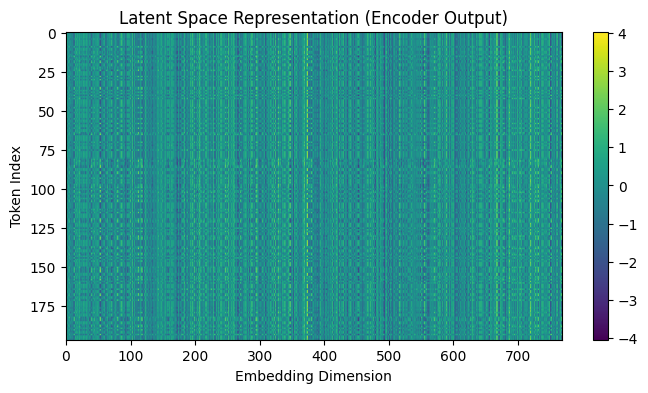

In [12]:
model.eval()  # Set the model in evaluation mode

# Prepare an example: load the first image from the dataset
example_img, _ = dataset[0]

# Convert the image to a tensor if needed (assuming your transforms did not already do so)
if not isinstance(example_img, torch.Tensor):
    example_img = transforms.ToTensor()(example_img)

# Add a batch dimension and move the image to the device (e.g., "cuda")
example_img = example_img.unsqueeze(0).to("cuda")

# Perform a forward pass through the encoder with no masking (mask_ratio=0)
with torch.no_grad():
    latent, mask, ids_restore = model.forward_encoder(example_img, mask_ratio=0)

# Print the shape of the latent representation and show some values
print("Latent Representation Shape:", latent.shape)
latent_np = latent.cpu().numpy()
print("First 5 latent vector values:", latent_np[0, :5])

plt.figure(figsize=(8, 4))
plt.imshow(latent_np[0], aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Latent Space Representation (Encoder Output)")
plt.xlabel("Embedding Dimension")
plt.ylabel("Token Index")
plt.show()

The 197 rows correspond to 196 patch tokens (from a 14×14 patch division) plus one extra token. In many transformer-based vision models, an additional token (often interpreted as a classification token) is appended to the patch tokens. Even though this extra token may not be used directly for classification in MAE pretraining, it is still included in the output, resulting in 197 rows. To analyze only the patch embeddings, we can use latent_np[0, :-1].

## MAE reconstruction

MAE employs two reconstruction strategies. One approach reconstructs patches in a normalized fashion, converting each token to its respective image patch and then normalizing it using the computed mean and standard deviation. This technique has been shown to yield better results in the original paper.

For visualization purposes, the model can be configured to reconstruct the actual intensity values by enabling the parameter "norm_pix_loss". This adjustment helps produce more interpretable reconstructions when analyzing the model’s performance.

In [13]:
import torch
from torch.utils.data import DataLoader
from models_mae import mae_vit_base_patch16

# Using the previously defined ALMADataset
# Adjust parameters as needed, e.g., use a small batch_size for testing
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Instantiate the model with minimal parameters
model = mae_vit_base_patch16(img_size=224, in_chans=1, norm_pix_loss=False) # trained with pixels as targets for visualization
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Run a simple pre-training for 2 epochs (adjust num_epochs as preferred)
device = "cuda" if torch.cuda.is_available() else "cpu"
pretrain_model(model, dataloader, optimizer, num_epochs=150, mask_ratio=0.75, device=device)

Epoch 1/150: Total Loss = 2.2328, MSE = 1.7916, MS-SSIM Loss = 0.4412


Epoch 2/150: Total Loss = 1.5235, MSE = 1.2756, MS-SSIM Loss = 0.2479


Epoch 3/150: Total Loss = 1.3429, MSE = 1.1760, MS-SSIM Loss = 0.1669


Epoch 4/150: Total Loss = 1.4110, MSE = 1.2409, MS-SSIM Loss = 0.1701


Epoch 5/150: Total Loss = 1.1626, MSE = 1.0384, MS-SSIM Loss = 0.1242


Epoch 6/150: Total Loss = 1.2567, MSE = 1.1193, MS-SSIM Loss = 0.1374


Epoch 7/150: Total Loss = 1.1655, MSE = 1.0466, MS-SSIM Loss = 0.1189


Epoch 8/150: Total Loss = 1.1944, MSE = 1.0859, MS-SSIM Loss = 0.1085


Epoch 9/150: Total Loss = 1.1423, MSE = 1.0345, MS-SSIM Loss = 0.1078


Epoch 10/150: Total Loss = 1.0830, MSE = 0.9733, MS-SSIM Loss = 0.1096


Epoch 11/150: Total Loss = 1.0884, MSE = 0.9938, MS-SSIM Loss = 0.0946


Epoch 12/150: Total Loss = 1.1914, MSE = 1.0934, MS-SSIM Loss = 0.0980


Epoch 13/150: Total Loss = 1.0916, MSE = 1.0097, MS-SSIM Loss = 0.0819


Epoch 14/150: Total Loss = 1.1370, MSE = 1.0527, MS-SSIM Loss = 0.0842


Epoch 15/150: Total Loss = 1.1295, MSE = 1.0331, MS-SSIM Loss = 0.0964


Epoch 16/150: Total Loss = 1.1857, MSE = 1.0917, MS-SSIM Loss = 0.0940


Epoch 17/150: Total Loss = 1.0623, MSE = 0.9613, MS-SSIM Loss = 0.1011


Epoch 18/150: Total Loss = 1.0798, MSE = 1.0076, MS-SSIM Loss = 0.0723


Epoch 19/150: Total Loss = 0.9633, MSE = 0.8905, MS-SSIM Loss = 0.0728


Epoch 20/150: Total Loss = 1.0726, MSE = 0.9939, MS-SSIM Loss = 0.0788


Epoch 21/150: Total Loss = 1.1152, MSE = 1.0428, MS-SSIM Loss = 0.0725


Epoch 22/150: Total Loss = 0.9540, MSE = 0.8826, MS-SSIM Loss = 0.0714


Epoch 23/150: Total Loss = 0.8646, MSE = 0.7971, MS-SSIM Loss = 0.0674


Epoch 24/150: Total Loss = 0.8565, MSE = 0.7891, MS-SSIM Loss = 0.0675


Epoch 25/150: Total Loss = 0.9366, MSE = 0.8669, MS-SSIM Loss = 0.0697


Epoch 26/150: Total Loss = 1.0375, MSE = 0.9174, MS-SSIM Loss = 0.1201


Epoch 27/150: Total Loss = 0.7634, MSE = 0.6931, MS-SSIM Loss = 0.0703


Epoch 28/150: Total Loss = 0.6739, MSE = 0.6142, MS-SSIM Loss = 0.0597


Epoch 29/150: Total Loss = 0.6739, MSE = 0.5999, MS-SSIM Loss = 0.0740


Epoch 30/150: Total Loss = 0.7154, MSE = 0.6453, MS-SSIM Loss = 0.0702


Epoch 31/150: Total Loss = 0.6211, MSE = 0.5623, MS-SSIM Loss = 0.0588


Epoch 32/150: Total Loss = 0.6262, MSE = 0.5614, MS-SSIM Loss = 0.0649


Epoch 33/150: Total Loss = 0.5554, MSE = 0.4995, MS-SSIM Loss = 0.0558


Epoch 34/150: Total Loss = 0.5367, MSE = 0.4912, MS-SSIM Loss = 0.0455


Epoch 35/150: Total Loss = 0.5117, MSE = 0.4618, MS-SSIM Loss = 0.0499


Epoch 36/150: Total Loss = 0.4372, MSE = 0.3889, MS-SSIM Loss = 0.0483


Epoch 37/150: Total Loss = 0.4902, MSE = 0.4437, MS-SSIM Loss = 0.0465


Epoch 38/150: Total Loss = 0.5436, MSE = 0.4938, MS-SSIM Loss = 0.0498


Epoch 39/150: Total Loss = 0.4496, MSE = 0.4026, MS-SSIM Loss = 0.0470


Epoch 40/150: Total Loss = 0.4716, MSE = 0.4272, MS-SSIM Loss = 0.0443


Epoch 41/150: Total Loss = 0.4355, MSE = 0.3959, MS-SSIM Loss = 0.0396


Epoch 42/150: Total Loss = 0.4074, MSE = 0.3716, MS-SSIM Loss = 0.0358


Epoch 43/150: Total Loss = 0.4306, MSE = 0.3959, MS-SSIM Loss = 0.0347


Epoch 44/150: Total Loss = 0.4413, MSE = 0.4023, MS-SSIM Loss = 0.0390


Epoch 45/150: Total Loss = 0.4056, MSE = 0.3657, MS-SSIM Loss = 0.0399


Epoch 46/150: Total Loss = 0.4563, MSE = 0.4139, MS-SSIM Loss = 0.0424


Epoch 47/150: Total Loss = 0.4312, MSE = 0.3870, MS-SSIM Loss = 0.0442


Epoch 48/150: Total Loss = 0.4707, MSE = 0.4156, MS-SSIM Loss = 0.0551


Epoch 49/150: Total Loss = 0.3906, MSE = 0.3520, MS-SSIM Loss = 0.0385


Epoch 50/150: Total Loss = 0.3913, MSE = 0.3534, MS-SSIM Loss = 0.0378


Epoch 51/150: Total Loss = 0.4084, MSE = 0.3741, MS-SSIM Loss = 0.0343


Epoch 52/150: Total Loss = 0.4402, MSE = 0.3881, MS-SSIM Loss = 0.0520


Epoch 53/150: Total Loss = 0.4577, MSE = 0.4125, MS-SSIM Loss = 0.0452


Epoch 54/150: Total Loss = 0.4225, MSE = 0.3803, MS-SSIM Loss = 0.0422


Epoch 55/150: Total Loss = 0.3745, MSE = 0.3319, MS-SSIM Loss = 0.0426


Epoch 56/150: Total Loss = 0.3840, MSE = 0.3485, MS-SSIM Loss = 0.0355


Epoch 57/150: Total Loss = 0.4806, MSE = 0.4434, MS-SSIM Loss = 0.0372


Epoch 58/150: Total Loss = 0.3973, MSE = 0.3604, MS-SSIM Loss = 0.0369


Epoch 59/150: Total Loss = 0.4419, MSE = 0.4009, MS-SSIM Loss = 0.0410


Epoch 60/150: Total Loss = 0.3746, MSE = 0.3394, MS-SSIM Loss = 0.0352


Epoch 61/150: Total Loss = 0.3638, MSE = 0.3325, MS-SSIM Loss = 0.0313


Epoch 62/150: Total Loss = 0.3472, MSE = 0.3137, MS-SSIM Loss = 0.0335


Epoch 63/150: Total Loss = 0.3674, MSE = 0.3339, MS-SSIM Loss = 0.0334


Epoch 64/150: Total Loss = 0.4437, MSE = 0.3958, MS-SSIM Loss = 0.0479


Epoch 65/150: Total Loss = 0.4022, MSE = 0.3614, MS-SSIM Loss = 0.0408


Epoch 66/150: Total Loss = 0.3910, MSE = 0.3559, MS-SSIM Loss = 0.0352


Epoch 67/150: Total Loss = 0.3923, MSE = 0.3549, MS-SSIM Loss = 0.0374


Epoch 68/150: Total Loss = 0.3608, MSE = 0.3303, MS-SSIM Loss = 0.0305


Epoch 69/150: Total Loss = 0.3278, MSE = 0.2988, MS-SSIM Loss = 0.0290


Epoch 70/150: Total Loss = 0.3366, MSE = 0.3060, MS-SSIM Loss = 0.0306


Epoch 71/150: Total Loss = 0.3676, MSE = 0.3370, MS-SSIM Loss = 0.0306


Epoch 72/150: Total Loss = 0.3305, MSE = 0.3028, MS-SSIM Loss = 0.0277


Epoch 73/150: Total Loss = 0.3554, MSE = 0.3219, MS-SSIM Loss = 0.0334


Epoch 74/150: Total Loss = 0.3271, MSE = 0.3008, MS-SSIM Loss = 0.0263


Epoch 75/150: Total Loss = 0.3660, MSE = 0.3365, MS-SSIM Loss = 0.0295


Epoch 76/150: Total Loss = 0.3375, MSE = 0.3054, MS-SSIM Loss = 0.0321


Epoch 77/150: Total Loss = 0.3293, MSE = 0.2974, MS-SSIM Loss = 0.0319


Epoch 78/150: Total Loss = 0.3110, MSE = 0.2864, MS-SSIM Loss = 0.0246


Epoch 79/150: Total Loss = 0.3601, MSE = 0.3279, MS-SSIM Loss = 0.0322


Epoch 80/150: Total Loss = 0.3705, MSE = 0.3389, MS-SSIM Loss = 0.0316


Epoch 81/150: Total Loss = 0.3222, MSE = 0.2897, MS-SSIM Loss = 0.0325


Epoch 82/150: Total Loss = 0.3094, MSE = 0.2843, MS-SSIM Loss = 0.0251


Epoch 83/150: Total Loss = 0.2940, MSE = 0.2657, MS-SSIM Loss = 0.0283


Epoch 84/150: Total Loss = 0.3130, MSE = 0.2877, MS-SSIM Loss = 0.0253


Epoch 85/150: Total Loss = 0.3020, MSE = 0.2793, MS-SSIM Loss = 0.0227


Epoch 86/150: Total Loss = 0.3162, MSE = 0.2873, MS-SSIM Loss = 0.0289


Epoch 87/150: Total Loss = 0.3240, MSE = 0.2959, MS-SSIM Loss = 0.0281


Epoch 88/150: Total Loss = 0.3124, MSE = 0.2815, MS-SSIM Loss = 0.0310


Epoch 89/150: Total Loss = 0.3230, MSE = 0.2854, MS-SSIM Loss = 0.0376


Epoch 90/150: Total Loss = 0.2954, MSE = 0.2690, MS-SSIM Loss = 0.0264


Epoch 91/150: Total Loss = 0.3298, MSE = 0.2971, MS-SSIM Loss = 0.0327


Epoch 92/150: Total Loss = 0.3322, MSE = 0.2977, MS-SSIM Loss = 0.0345


Epoch 93/150: Total Loss = 0.3687, MSE = 0.3386, MS-SSIM Loss = 0.0301


Epoch 94/150: Total Loss = 0.3397, MSE = 0.3070, MS-SSIM Loss = 0.0327


Epoch 95/150: Total Loss = 0.3337, MSE = 0.3061, MS-SSIM Loss = 0.0275


Epoch 96/150: Total Loss = 0.3192, MSE = 0.2884, MS-SSIM Loss = 0.0308


Epoch 97/150: Total Loss = 0.3138, MSE = 0.2873, MS-SSIM Loss = 0.0264


Epoch 98/150: Total Loss = 0.2823, MSE = 0.2604, MS-SSIM Loss = 0.0219


Epoch 99/150: Total Loss = 0.2842, MSE = 0.2624, MS-SSIM Loss = 0.0218


Epoch 100/150: Total Loss = 0.2937, MSE = 0.2711, MS-SSIM Loss = 0.0226


Epoch 101/150: Total Loss = 0.3090, MSE = 0.2755, MS-SSIM Loss = 0.0335


Epoch 102/150: Total Loss = 0.3099, MSE = 0.2819, MS-SSIM Loss = 0.0280


Epoch 103/150: Total Loss = 0.3614, MSE = 0.3316, MS-SSIM Loss = 0.0298


Epoch 104/150: Total Loss = 0.3359, MSE = 0.3048, MS-SSIM Loss = 0.0311


Epoch 105/150: Total Loss = 0.2630, MSE = 0.2397, MS-SSIM Loss = 0.0233


Epoch 106/150: Total Loss = 0.2907, MSE = 0.2660, MS-SSIM Loss = 0.0247


Epoch 107/150: Total Loss = 0.3117, MSE = 0.2867, MS-SSIM Loss = 0.0249


Epoch 108/150: Total Loss = 0.2936, MSE = 0.2669, MS-SSIM Loss = 0.0267


Epoch 109/150: Total Loss = 0.2618, MSE = 0.2371, MS-SSIM Loss = 0.0247


Epoch 110/150: Total Loss = 0.2832, MSE = 0.2571, MS-SSIM Loss = 0.0261


Epoch 111/150: Total Loss = 0.3108, MSE = 0.2847, MS-SSIM Loss = 0.0261


Epoch 112/150: Total Loss = 0.3055, MSE = 0.2792, MS-SSIM Loss = 0.0263


Epoch 113/150: Total Loss = 0.2806, MSE = 0.2514, MS-SSIM Loss = 0.0293


Epoch 114/150: Total Loss = 0.2806, MSE = 0.2571, MS-SSIM Loss = 0.0235


Epoch 115/150: Total Loss = 0.3027, MSE = 0.2769, MS-SSIM Loss = 0.0258


Epoch 116/150: Total Loss = 0.2839, MSE = 0.2579, MS-SSIM Loss = 0.0260


Epoch 117/150: Total Loss = 0.3136, MSE = 0.2879, MS-SSIM Loss = 0.0257


Epoch 118/150: Total Loss = 0.2894, MSE = 0.2663, MS-SSIM Loss = 0.0231


Epoch 119/150: Total Loss = 0.2951, MSE = 0.2703, MS-SSIM Loss = 0.0247


Epoch 120/150: Total Loss = 0.2952, MSE = 0.2708, MS-SSIM Loss = 0.0245


Epoch 121/150: Total Loss = 0.2782, MSE = 0.2538, MS-SSIM Loss = 0.0244


Epoch 122/150: Total Loss = 0.2687, MSE = 0.2444, MS-SSIM Loss = 0.0242


Epoch 123/150: Total Loss = 0.2753, MSE = 0.2535, MS-SSIM Loss = 0.0218


Epoch 124/150: Total Loss = 0.2687, MSE = 0.2391, MS-SSIM Loss = 0.0296


Epoch 125/150: Total Loss = 0.2869, MSE = 0.2617, MS-SSIM Loss = 0.0251


Epoch 126/150: Total Loss = 0.2686, MSE = 0.2400, MS-SSIM Loss = 0.0287


Epoch 127/150: Total Loss = 0.3557, MSE = 0.3255, MS-SSIM Loss = 0.0302


Epoch 128/150: Total Loss = 0.2970, MSE = 0.2729, MS-SSIM Loss = 0.0241


Epoch 129/150: Total Loss = 0.2804, MSE = 0.2585, MS-SSIM Loss = 0.0218


Epoch 130/150: Total Loss = 0.2733, MSE = 0.2516, MS-SSIM Loss = 0.0217


Epoch 131/150: Total Loss = 0.2564, MSE = 0.2324, MS-SSIM Loss = 0.0240


Epoch 132/150: Total Loss = 0.2634, MSE = 0.2348, MS-SSIM Loss = 0.0287


Epoch 133/150: Total Loss = 0.2595, MSE = 0.2380, MS-SSIM Loss = 0.0216


Epoch 134/150: Total Loss = 0.2565, MSE = 0.2352, MS-SSIM Loss = 0.0213


Epoch 135/150: Total Loss = 0.2750, MSE = 0.2528, MS-SSIM Loss = 0.0221


Epoch 136/150: Total Loss = 0.2929, MSE = 0.2660, MS-SSIM Loss = 0.0269


Epoch 137/150: Total Loss = 0.2791, MSE = 0.2545, MS-SSIM Loss = 0.0246


Epoch 138/150: Total Loss = 0.2619, MSE = 0.2403, MS-SSIM Loss = 0.0215


Epoch 139/150: Total Loss = 0.2778, MSE = 0.2546, MS-SSIM Loss = 0.0232


Epoch 140/150: Total Loss = 0.2867, MSE = 0.2627, MS-SSIM Loss = 0.0240


Epoch 141/150: Total Loss = 0.2842, MSE = 0.2577, MS-SSIM Loss = 0.0265


Epoch 142/150: Total Loss = 0.2540, MSE = 0.2328, MS-SSIM Loss = 0.0212


Epoch 143/150: Total Loss = 0.2875, MSE = 0.2622, MS-SSIM Loss = 0.0252


Epoch 144/150: Total Loss = 0.2844, MSE = 0.2606, MS-SSIM Loss = 0.0238


Epoch 145/150: Total Loss = 0.2505, MSE = 0.2286, MS-SSIM Loss = 0.0219


Epoch 146/150: Total Loss = 0.2503, MSE = 0.2280, MS-SSIM Loss = 0.0223


Epoch 147/150: Total Loss = 0.2515, MSE = 0.2314, MS-SSIM Loss = 0.0201


Epoch 148/150: Total Loss = 0.3077, MSE = 0.2847, MS-SSIM Loss = 0.0231


Epoch 149/150: Total Loss = 0.2994, MSE = 0.2695, MS-SSIM Loss = 0.0299


Epoch 150/150: Total Loss = 0.2769, MSE = 0.2537, MS-SSIM Loss = 0.0232


MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2

In [14]:
def show_image(image, title=''):
    # image_norm = torch.clip((image * global_std + global_mean) * 255, 0, 255).int()
    plt.imshow(image, cmap='gray')
    plt.colorbar()
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def run_one_image(img, model):
    """
    Process a single image through the MAE model to obtain the reconstruction.
    Adapted for single-channel input images.
    """
    # Ensure image has shape [H, W, 1]
    if img.ndim == 2:
        img = np.expand_dims(img, axis=-1)
    
    x = torch.tensor(img)  # shape: H x W x 1
    x = x.unsqueeze(0)     # add batch dimension: 1 x H x W x 1
    x = torch.einsum('nhwc->nchw', x)  # convert to [B, C, H, W]
    
    # Run the MAE forward pass with mask_ratio=0.75 (as used during training)
    with torch.no_grad():
        _, _, y, mask = model(x.float(), mask_ratio=0.75)
    
    # Reconstruct image from patches
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    
    # Process the mask:
    # Since the data is single-channel, repeat once to match the number of pixels in a patch.
    mask = mask.detach().unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 * 1)
    mask = model.unpatchify(mask)
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)
    
    # Create masked image and pasted reconstruction image
    im_masked = x * (1 - mask)
    im_paste = x * (1 - mask) + y * mask
    
    plt.rcParams['figure.figsize'] = [30, 5]
    plt.subplot(1, 4, 1)
    show_image(x[0].cpu().numpy(), "Original")
    
    plt.subplot(1, 4, 2)
    show_image(im_masked[0].cpu().numpy(), "Masked")
    
    plt.subplot(1, 4, 3)
    show_image(y[0].cpu().numpy(), "Reconstruction")
    
    plt.subplot(1, 4, 4)
    show_image(im_paste[0].cpu().numpy(), "Reconstruction + Visible")
    
    plt.show()

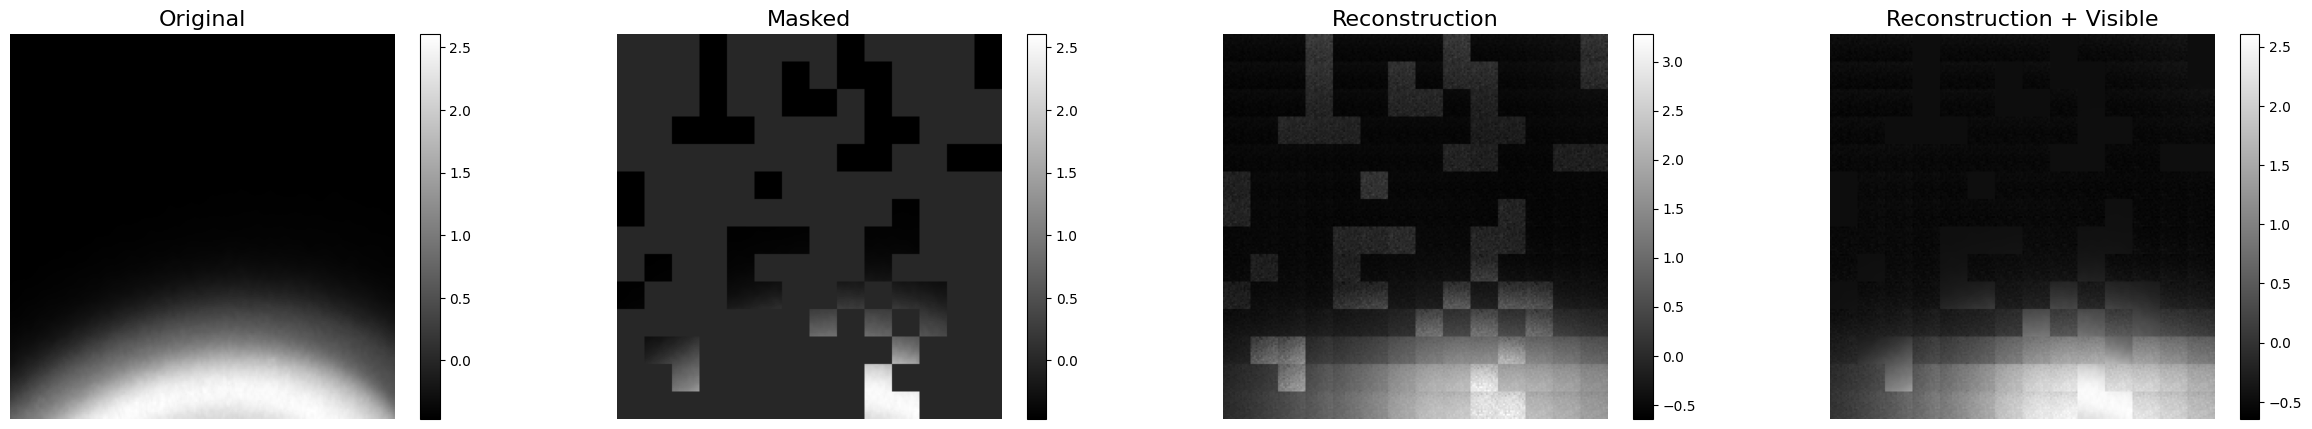

In [15]:
# Example:
model = model.to('cpu')
example_img = dataset[0][0][0]  # your dataset returns a single-channel image
run_one_image(example_img, model)

In [16]:
torch.cuda.empty_cache()
import gc
gc.collect()

26362